In [1]:
import numpy as np
import pandas as pd
import warnings
import random
import h5py
import torch
import matplotlib.pyplot as plt
import torch.nn as nn

from matplotlib import pyplot
from IPython.display import display
from torch.utils.data import DataLoader, Dataset
from torch.utils import data
from PIL import Image, ImageDraw


warnings.filterwarnings('ignore')

%matplotlib inline

SEED = 21
random.seed(SEED)
np.random.seed(SEED)

In [2]:
from torchvision import transforms

device = ("cuda" if torch.cuda.is_available() else "cpu")
learning_rate = 0.01
image_size = 96

train_transforms = transforms.Compose([
    transforms.RandomChoice([
        transforms.ColorJitter(brightness=0.5),
        transforms.ColorJitter(contrast=0.5), 
        transforms.ColorJitter(saturation=0.5),
        transforms.ColorJitter(hue=0.5),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1), 
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.3), 
        transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5), 
    ]),
    transforms.RandomChoice([
        transforms.RandomRotation((0, 0)),
        transforms.RandomHorizontalFlip(p=1),
        transforms.RandomVerticalFlip(p=1),
        transforms.RandomRotation((90,90)),
        transforms.RandomRotation((180,180)),
        transforms.RandomRotation((270,270)),
        transforms.Compose([
            transforms.RandomHorizontalFlip(p=1),
            transforms.RandomRotation((90,90)),
        ]),
        transforms.Compose([
            transforms.RandomHorizontalFlip(p=1),
            transforms.RandomRotation((270,270)),
        ]) 
    ]),
    transforms.Resize(image_size), 
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

print(device)

cuda


In [3]:
class PCamDataset(Dataset):
    def __init__(self, path, transforms):
        self.path = path
        self.X = h5py.File(self.path +'_x.h5', 'r')['x']
        self.y = h5py.File(self.path +'_y.h5', 'r')['y']
        self.transforms = transforms

    def __getitem__(self, index):
        return (self.transforms(Image.fromarray(self.X[index,:,:,:])), self.y[index])

    def __len__(self):
        assert len(self.X) == len(self.y)
        return len(self.X)

In [4]:
data_dir = "../input/patchcamelyon/"

train = PCamDataset(data_dir + "camelyonpatch_level_2_split_train", train_transforms)
valid = PCamDataset(data_dir + "camelyonpatch_level_2_split_valid", test_transforms)
test = PCamDataset(data_dir + "camelyonpatch_level_2_split_test", test_transforms)

print(len(train), len(valid), len(test))

262144 32768 32768


In [5]:
train_loader = DataLoader(train, batch_size=8, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid, batch_size=8, shuffle=False, num_workers=0)
test_loader = DataLoader(test, batch_size=8, shuffle=False, num_workers=0)

In [6]:
import torch.nn.functional as F

class PCamNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=2)
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=2)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=2)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=2)
        self.bn4 = nn.BatchNorm2d(256)
        
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=2)
        self.bn5 = nn.BatchNorm2d(512)
        
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.avg = nn.AvgPool2d(4)
        
        self.fc = nn.Linear(512, 1)
        
    def forward(self, x):
        x = self.maxpool(F.leaky_relu(self.bn1(self.conv1(x))))
        x = self.maxpool(F.leaky_relu(self.bn2(self.conv2(x))))
        x = self.maxpool(F.leaky_relu(self.bn3(self.conv3(x))))
        x = self.maxpool(F.leaky_relu(self.bn4(self.conv4(x))))
        x = self.maxpool(F.leaky_relu(self.bn5(self.conv5(x))))
        x = self.avg(x)
        x = x.view(-1, 512)
        x = self.fc(x)
        return x

In [7]:
model = PCamNet()

In [8]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.BCEWithLogitsLoss()

In [9]:
print(f"Total number of model parameters = {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

Total number of model parameters = 1571073


In [10]:
%%time

from sklearn.metrics import roc_auc_score

epochs = 20
train_loss_history = np.empty(0)
train_accuracy_history = np.empty(0)
valid_loss_history = np.empty(0)
valid_accuracy_history = np.empty(0)
best_roc_auc = 0

model = model.to(device)

model.train()
for epoch in range(epochs):
    preds_in_current_epoch = torch.empty(0, device=device)
    labels_in_current_epoch = torch.empty(0, device=device)
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        target = torch.reshape(target, (8, 1)).float()
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, target)
        loss.backward()
        optimizer.step()
        preds_in_current_epoch = torch.cat((preds_in_current_epoch, torch.sigmoid(out)))
        labels_in_current_epoch = torch.cat((labels_in_current_epoch, target))
    
    labels_in_current_epoch = torch.squeeze(labels_in_current_epoch)
    total = len(labels_in_current_epoch)
    preds_in_current_epoch = torch.squeeze(preds_in_current_epoch)
    correct = ((preds_in_current_epoch > 0.5).float() == labels_in_current_epoch).sum().item()
    loss = criterion(preds_in_current_epoch, labels_in_current_epoch)
    accuracy = round(correct / total, 4)
    
    train_accuracy_history = np.append(train_accuracy_history, accuracy)
    train_loss_history = np.append(train_loss_history, loss.cpu().detach().numpy())

    print(f"Train Epoch: {epoch + 1}, Loss: {loss}, Accuracy: {accuracy}")
    
    valid_labels = (torch.squeeze(torch.as_tensor(valid.y))).to(device)

    with torch.no_grad():
        predictions = torch.Tensor().float().to(device)

        for batch_idx, (data, target) in enumerate(valid_loader):
            data, target = data.to(device), target.to(device)
            target = torch.reshape(target, (8, 1)).float()
            out = model(data)
            predictions = torch.cat((predictions, torch.sigmoid(out)))

        total = valid_labels.shape[0]
        predictions = torch.squeeze(predictions)
        correct = ((predictions > 0.5).float() == valid_labels).sum().item()
        loss = criterion(predictions, valid_labels.float())
        accuracy = round(correct / total, 4)
                                    
        valid_accuracy_history = np.append(valid_accuracy_history, accuracy)
        valid_loss_history = np.append(valid_loss_history, loss.cpu().detach().numpy())

        print(f"Valid Loss: {loss}, Valid Accuracy: {accuracy}")
        
        current_roc_auc = roc_auc_score(valid_labels.cpu().detach().numpy(), predictions.cpu().detach().numpy())
        print(f"ROC-AUC score = {current_roc_auc}")
        if current_roc_auc > best_roc_auc:
            torch.save(model.state_dict(), "best_auc_checkpoint.pth")
            print("Model saved successfully\n")
            best_roc_auc = current_roc_auc

model.eval()
torch.save(model.state_dict(), "checkpoint.pth")

Train Epoch: 1, Loss: 0.6246044635772705, Accuracy: 0.8028
Valid Loss: 0.620112419128418, Valid Accuracy: 0.8083
ROC-AUC score = 0.8884528834443495
Model saved successfully

Train Epoch: 2, Loss: 0.589584469795227, Accuracy: 0.8655
Valid Loss: 0.592958390712738, Valid Accuracy: 0.8291
ROC-AUC score = 0.9108615422392152
Model saved successfully

Train Epoch: 3, Loss: 0.5790666937828064, Accuracy: 0.8828
Valid Loss: 0.5902153253555298, Valid Accuracy: 0.8391
ROC-AUC score = 0.9200710952877865
Model saved successfully

Train Epoch: 4, Loss: 0.5727729201316833, Accuracy: 0.8934
Valid Loss: 0.5929149985313416, Valid Accuracy: 0.8514
ROC-AUC score = 0.928065602908882
Model saved successfully

Train Epoch: 5, Loss: 0.5681663155555725, Accuracy: 0.9008
Valid Loss: 0.5891514420509338, Valid Accuracy: 0.8379
ROC-AUC score = 0.919051322290851
Train Epoch: 6, Loss: 0.5653880834579468, Accuracy: 0.9052
Valid Loss: 0.5816513299942017, Valid Accuracy: 0.8327
ROC-AUC score = 0.924738250919083
Train Ep

In [11]:
from sklearn.metrics import classification_report

classes = ['+', '-']
test_labels = (torch.squeeze(torch.Tensor(test.y))).to(device)

with torch.no_grad():
    predictions = torch.empty(0, device=device)
    
    for batch_idx, (data, target) in enumerate(test_loader):
        data, target = data.to(device), target.to(device)
        target = torch.reshape(target, (8, 1)).float()
        out = model(data)
        loss = criterion(out, target)
        predictions = torch.cat((predictions, torch.sigmoid(out)))
                                
    total = test_labels.shape[0]
    predictions = torch.squeeze(predictions)
    correct = ((predictions > 0.5).float() == test_labels).sum().item()
    loss = criterion(predictions, test_labels)
    accuracy = round(correct / total, 5)
                                
    print(f"Test Loss: {loss}\nTest Accuracy: {accuracy}")
    
    predictions = predictions.cpu().detach().numpy()
    for i in range(len(predictions)):
        predictions[i] = 1.0 if predictions[i] > 0.5 else 0.0
    
    print(classification_report(test_labels.cpu().detach().numpy(), 
                                predictions, 
                                target_names=classes))
    print(f"ROC-AUC = {roc_auc_score(test_labels.cpu().detach().numpy(), predictions)}")

Test Loss: 0.5700723528862
Test Accuracy: 0.85117
              precision    recall  f1-score   support

           +       0.79      0.97      0.87     16391
           -       0.96      0.74      0.83     16377

    accuracy                           0.85     32768
   macro avg       0.87      0.85      0.85     32768
weighted avg       0.87      0.85      0.85     32768

ROC-AUC = 0.8511167064484901


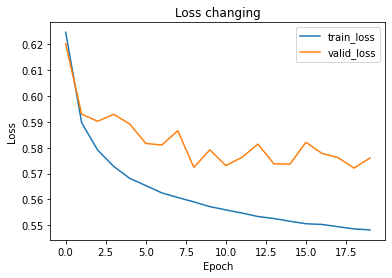

In [12]:
train_loss_idx = list(range(0, len(train_loss_history)))
valid_loss_idx = list(range(0, len(valid_loss_history)))

plt.plot(train_loss_idx, train_loss_history, label="train_loss")
plt.plot(valid_loss_idx, valid_loss_history, label="valid_loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.title("Loss changing")

plt.legend()
plt.show()

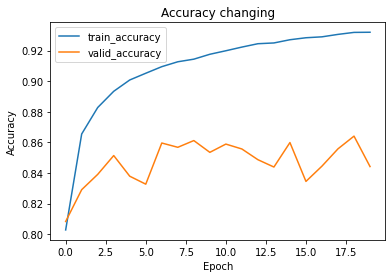

In [13]:
train_accuracy_idx = list(range(0, len(train_accuracy_history)))
valid_accuracy_idx = list(range(0, len(valid_accuracy_history)))

plt.plot(train_accuracy_idx, train_accuracy_history, label="train_accuracy")
plt.plot(valid_accuracy_idx, valid_accuracy_history, label="valid_accuracy")

plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.title("Accuracy changing")

plt.legend()
plt.show()